In [37]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\Sizov\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


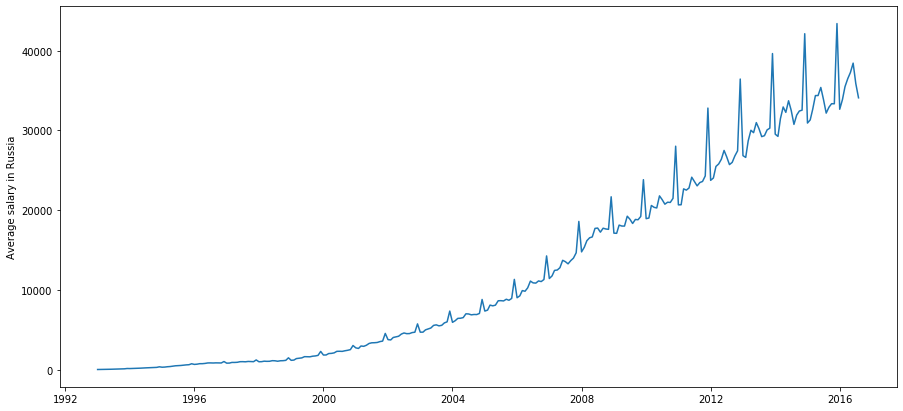

In [38]:
salary = pd.read_csv('salary.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
plt.plot(salary)
plt.ylabel('Average salary in Russia')
plt.show()

We can notice an increasing trend, seasonality and growth of dispertion. The row is obviously nonstationary.

# Stabilisation of a dispertion (The Box-Cox Transformation)

Optimal parameter of Box-Cox Transformation: 0.263202
Dickey–Fuller test: p=0.696899


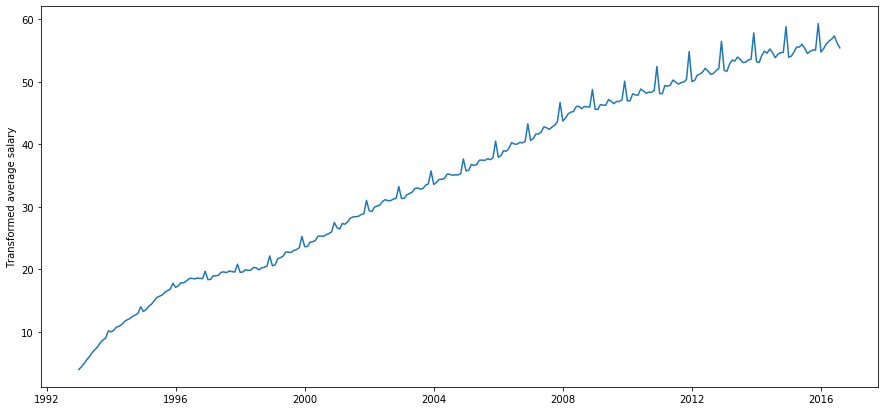

In [39]:
salary['box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
plt.plot(salary.box)
plt.ylabel(u'Transformed average salary')
print("Optimal parameter of Box-Cox Transformation: %f" % lmbda)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(salary.box)[1])

Dickey-Fuller's criteria does not deny the non-stationnarity of the row. Besides, we can still see a positive trend in data, so we will apply seasonal and, if needed, ordinary differentiation

Dickey-Fuller's criteriа: p=0.014697


<Figure size 1080x504 with 0 Axes>

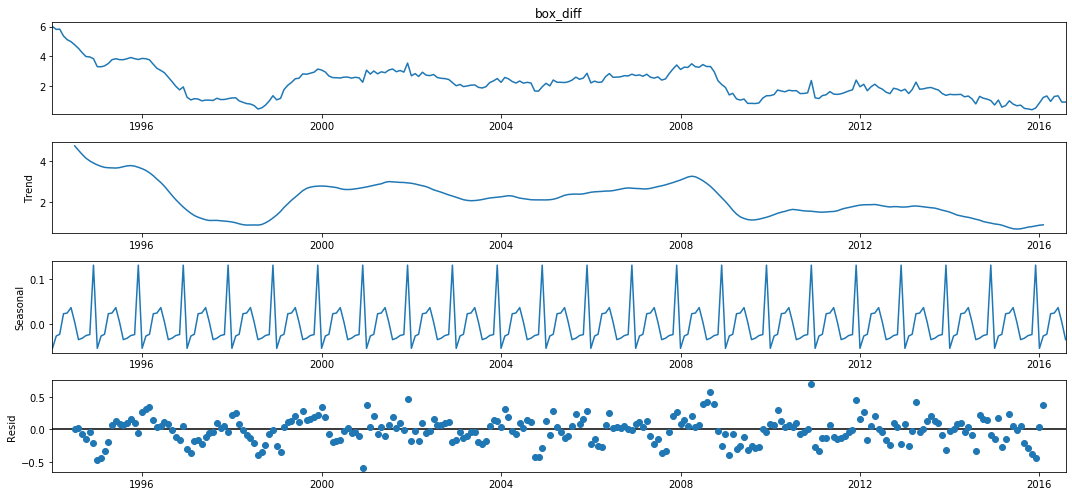

In [40]:
salary['box_diff'] = salary.box - salary.box.shift(12)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(salary.box_diff[12:]).plot()
print("Dickey-Fuller's criteriа: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff[12:])[1])

Dickey-Fuller's criteriа does not deny the stationarity, but we still have a trend. Let us try an ordinary differention

Dickey-Fuller's criteriа: p=0.000000


<Figure size 1080x504 with 0 Axes>

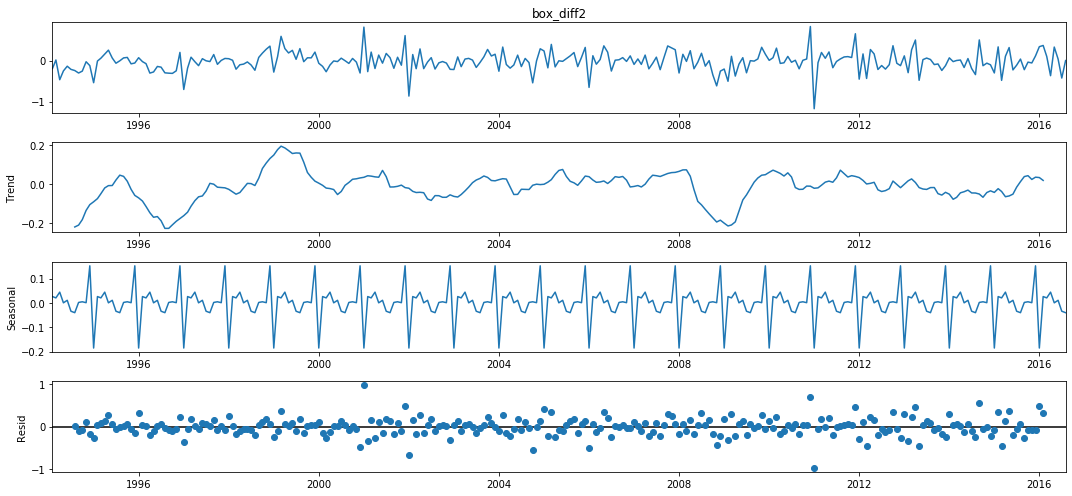

In [41]:
salary['box_diff2'] = salary.box_diff - salary.box_diff.shift(1)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(salary.box_diff2[13:]).plot()
print("Dickey-Fuller's criteriа: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff2[13:])[1])

Dickey-Fuller's criteriа says that the row is stationnaire now, moreover we have got rid of the trend. So d = 1 (ordinary differential) and D = 1 (seasonal differential). Now we have to determine the other parameters of ARIMA

# Selection of other parameters of ARIMA

It is known that the initial approach to (q, Q) are chosen with the help of an auto-correlation function, and (p, P) are found by the graph of a partial auto-correlation function

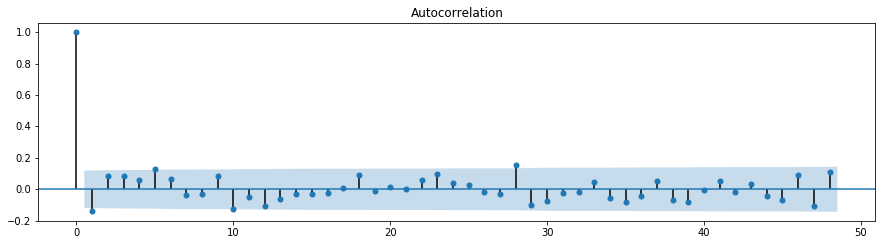

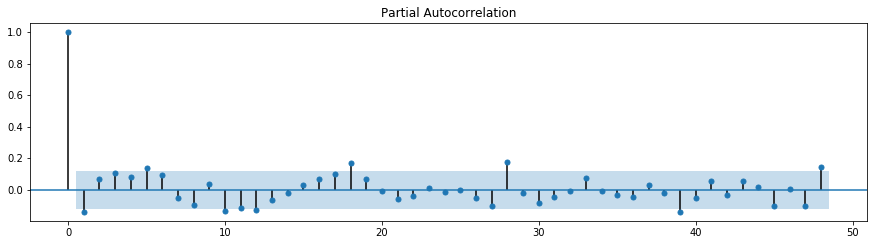

In [42]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

There is no seasonality in the auto-correlation function, so Q = 0. q = 1, because other significant q's are too big and are not suitable for an initial approach

P = 3, p = 1. 

In [43]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 4)
D=1
Qs = range(0, 1)

In [44]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [45]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 14.4 s


In [46]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
9   (1, 0, 1, 0)  0.340521
5   (0, 1, 1, 0)  1.170768
10  (1, 0, 2, 0)  1.622924
13  (1, 1, 1, 0)  2.021911
6   (0, 1, 2, 0)  2.509650


In [47]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Thu, 30 Jul 2020   AIC                              0.341
Time:                                    23:58:08   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Student's criteria: p=0.090798
Dickey-Fuller's criteriа: p=0.000003


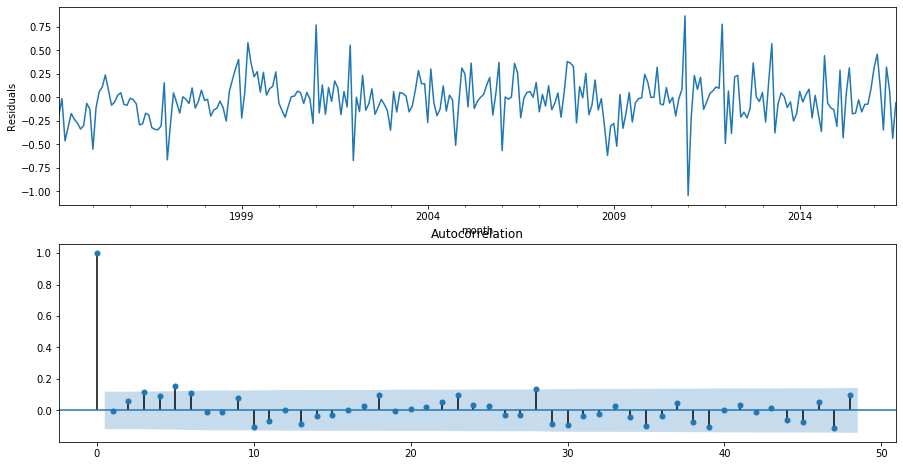

In [48]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's criteria: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller's criteriа: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

The residuals are unbised (we can see it from the plot of residuals) and stationaire according to Dickey-Fuller's criteriа. They are also not auto-correlated according to the correlogram, which means that we have taken into account all the structure of our data

# Verification

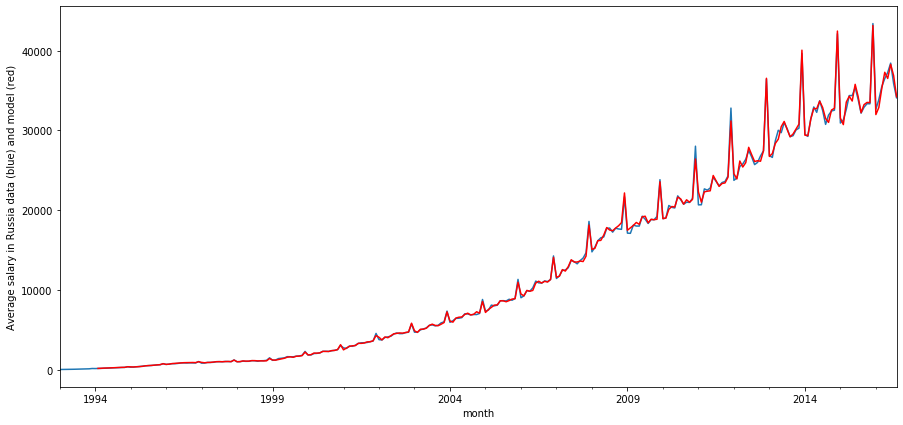

In [50]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Average salary in Russia data (blue) and model (red)' )
pylab.show()

The model agrees quite well with the data, now let us predict the future behaviour

# Prediction

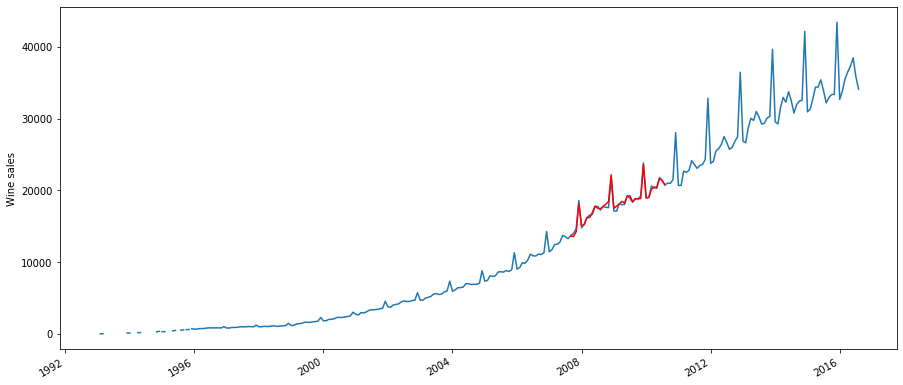

In [67]:
salary2 =salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("1993-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

In [56]:
print(salary.index[0])

1993-01-01 00:00:00
